In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

MNIST_WIDTH = 28
NVISIBLE = MNIST_WIDTH**2
NHIDDEN = 500
CORRUPTION_LEVEL = 0.3
BATCH_SIZE = 128

In [40]:
fig = plt.figure(figsize=(10,10))


<Figure size 720x720 with 0 Axes>

In [ ]:
fig.suptitle

In [41]:
def vis(images, name):
    dim = images.shape[0]
    n_images_rows = int(np.ceil(np.sqrt(dim)))
    n_images_cols = int(np.ceil(dim * 1.0/n_images_rows))
    gs = gridspec.GridSpec(n_images_rows, n_images_cols)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(name)
    for g, count in zip(gs, range(dim)):
        ax = plt.subplot(g)
        ax.imshow(images[count, :].reshape(28, 28))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
def get_weight(shape, name):
    in_size = shape[0]
    out_size = shape[1]
    W_init_max = 4 * np.sqrt(6. / (in_size + out_size))
    W_init = tf.random_uniform(shape = shape, 
                               minval=-W_init_max, 
                               maxval=W_init_max)
    
    W = tf.Variable(W_init, name = name)
    return W
    
def get_bias(shape, name):
    b = tf.Variable(tf.zeros(shape = shape), name = name)
    return b

def get_model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X #corrupted X
    
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z

In [22]:
#create node for input data
X = tf.placeholder("float", [None, NVISIBLE], name = "X")
#create node for corruption mask
mask = tf.placeholder("float", [None, NVISIBLE], name = "mask")

W = get_weight(shape = [NVISIBLE, NHIDDEN], name = "W")
b = get_bias(shape = [NHIDDEN], name = "b")

W_prime = tf.transpose(W)
b_prime = get_bias(shape = [NVISIBLE], name = "b_prime")


Z = get_model(X, mask, W, b, W_prime, b_prime)

#create cost function

cost = tf.reduce_sum(tf.pow(X - Z, 2)) #minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost) #constract an optimizer
predict_op = Z

In [23]:
#load data

mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
X_train, y_train, X_test, y_test = mnist.train.images, \
                                   mnist.train.labels, \
                                   mnist.test.images, \
                                   mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:
with tf.Session() as sess:
    #you need to initialize all variables
    tf.global_variables_initializer().run()
    
    for i in range(10):
        for start, end in zip(range(0, len(X_train), BATCH_SIZE), 
                              range(BATCH_SIZE, len(X_train), BATCH_SIZE)):
            X_train_batch = X_train[start:end]
            mask_val = np.random.binomial(1, 
                                          1 - CORRUPTION_LEVEL, 
                                          X_train_batch.shape)
            sess.run(train_op, feed_dict = {X: X_train_batch, mask: mask_val})
        mask_np = np.random.binomial(1, 1 - CORRUPTION_LEVEL, X_test.shape)
        print(i, sess.run(cost, feed_dict = {X: X_test, mask: mask_np}))
        
    
    mask_np = np.random.binomial(1, 1 - CORRUPTION_LEVEL, X_test[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict = {X: X_test[:100], mask:mask_np})

0 113434.34
1 95268.08
2 86400.76
3 80159.414
4 78394.45
5 75382.734
6 72158.64
7 71854.28
8 70041.67
9 68533.086


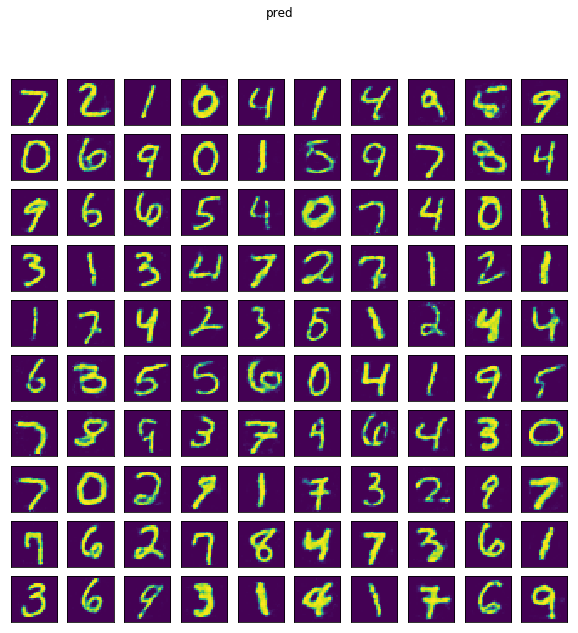

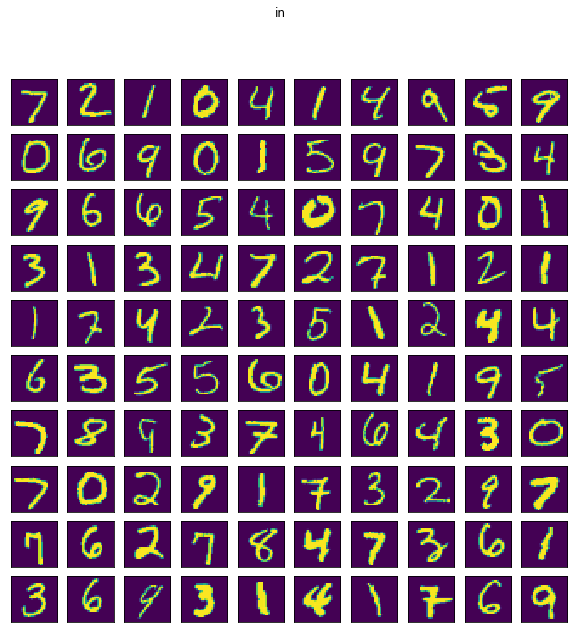

In [42]:
vis(predicted_imgs, "pred")
vis(X_test[:100], "in")